In [1]:
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import numpy as np
from plotter import Plotter
import dolfin as df
from ffian.project_flow_models import ModelMC1, ModelMC2, ModelMC3, ModelMC4, ModelMC5
import inspect

%matplotlib inline

In [12]:
class PlotObject:
    def __init__(self, model_v, point_time=1.5e-4, n=None):
#         with open(f'results/stimulation_data/timedata/{model_v}.pkl', 'rb') as f:  # Python 3: open(..., 'rb')
#             if model_v == 'MC3' or model_v == 'MC5':
#                 [j_ins, j_decs, dalpha_is, dalpha_es, 
#                  Na_is, Na_es, K_is, K_es, Cl_is, Cl_es, HCO3_is, HCO3_es, 
#                  p_ms, phi_ms, j_pumps] = pickle.load(f)
#                 self.HCO3_is = HCO3_is
#                 self.HCO3_es = HCO3_es
#             else:
#                 [j_ins, j_decs, dalpha_is, dalpha_es, 
#                  Na_is, Na_es, K_is, K_es, Cl_is, Cl_es, 
#                  p_ms, phi_ms, j_pumps] = pickle.load(f)
#             self.j_in = j_ins
#             self.j_dec = j_decs
#             self.dalpha_i = dalpha_is
#             self.dalpha_e = dalpha_es
#             self.Na_i = Na_is
#             self.Na_e = Na_es
#             self.K_i = K_is
#             self.K_e = K_es
#             self.Cl_i = Cl_is
#             self.Cl_e = Cl_es
#             self.p_m = p_ms
#             self.phi_m = phi_ms
#             self.j_pump = j_pumps
            
        j_in = 1.0e-6                # input constant (mol/(m^2s))
        Tstop = 60                   # duration of simulation (s)
        stim_start = 10              # stimulus onset (s)
        stim_end = 20                # stimulus offset (s)
        if n is None:
            n = stim_end
        stim_protocol = 'constant'   # stimulus protocol ('constant', 'slow', or 'ultraslow')
        # mesh
        N = 400                                  # mesh size
        L = 3.0e-4                               # m (300 um)
        mesh = df.IntervalMesh(N, 0, L)          # create mesh
        
        # model setup
        t_PDE = df.Constant(0.0)  # time constant
        class_name = f"Model{model_v}"
        if class_name in globals() and inspect.isclass(globals()[class_name]):
            model_type = globals()[class_name]
        model = model_type(model_v, mesh, L, t_PDE, j_in, stim_start, stim_end, stim_protocol)
        self.model = model
        path_data = 'results/data/' + model_v + '/'
        path_figs = 'results/figures/'
        P = Plotter(model, path_data)

        # time variables
        dt_value = 1e-3                          # time step (s)
        
        # get parameters
        K_m = model.params['K_m']
        p_m_init = model.params['p_m_init']
        alpha_i_init = float(model.alpha_i_init)
        alpha_e_init = float(model.alpha_e_init)

        # point in space at which to use in timeplots
        point = point_time

        # range of t values
        xlim_T = [0.0, Tstop]

        # list of function values at point
        j_ins = []
        j_decs = []
        j_pumps = []
        Na_is = []
        K_is = []
        Cl_is = []
        HCO3_is = []
        Na_es = []
        K_es = []
        Cl_es = []
        HCO3_es = []
        dalpha_is = []
        dalpha_es = []
        p_ms = []
        phi_ms = []

        for n in range(Tstop+1):

            # get data
            alpha_i = P.read_from_file(n, 0)
            Na_i = P.read_from_file(n, 1)
            Na_e = P.read_from_file(n, 2)
            K_i = P.read_from_file(n, 3)
            K_e = P.read_from_file(n, 4)
            Cl_i = P.read_from_file(n, 5)
            Cl_e = P.read_from_file(n, 6)
            if model_v == 'MC3' or model_v == 'MC5':
                HCO3_i = P.read_from_file(n, 7)
                HCO3_e = P.read_from_file(n, 8)
                phi_i = P.read_from_file(n, 9)
                phi_e = P.read_from_file(n, 10)
            else:
                phi_i = P.read_from_file(n, 7)
                phi_e = P.read_from_file(n, 8)

            # calculate extracellular volume fraction
            alpha_e = 0.6 - alpha_i(point)

            # get input/decay fluxes
            j_in_ = model.j_in(n)
            j_dec_ = model.j_dec(K_e)
            j_pump_ = model.j_pump(K_e, Na_i)
            j_in = P.project_to_function_space(j_in_*1e6)    # convert to umol/(m^2s)
            j_dec = P.project_to_function_space(j_dec_*1e6)  # convert to umol/(m^2s)
            j_pump = P.project_to_function_space(j_pump_*1e6)# convert to umol/(m^2s)

            # calculate change in volume fractions
            alpha_i_diff = (alpha_i(point) - alpha_i_init)/alpha_i_init*100
            alpha_e_diff = (alpha_e - alpha_e_init)/alpha_e_init*100

            # calculate transmembrane hydrostatic pressure
            tau = K_m*(alpha_i(point) - alpha_i_init)
            p_m = tau + p_m_init

            # calculate membrane potential
            phi_m = (phi_i(point) - phi_e(point))*1000  # convert to mV

            # append data to lists
            j_ins.append(j_in(point))
            j_decs.append(j_dec(point))
            j_pumps.append(j_pump(point))
            Na_is.append(Na_i(point))
            K_is.append(K_i(point))
            Cl_is.append(Cl_i(point))
            Na_es.append(Na_e(point))
            K_es.append(K_e(point))
            Cl_es.append(Cl_e(point))
            if model_v == 'MC3' or model_v == 'MC5':
                HCO3_is.append(HCO3_i(point))
                HCO3_es.append(HCO3_e(point))
            dalpha_is.append(alpha_i_diff)
            dalpha_es.append(alpha_e_diff)
            p_ms.append(float(p_m))
            phi_ms.append(phi_m)
        
        if model_v == 'MC3' or model_v == 'MC5':
            self.HCO3_is = HCO3_is
            self.HCO3_es = HCO3_es
        self.j_in = j_ins
        self.j_dec = j_decs
        self.dalpha_i = dalpha_is
        self.dalpha_e = dalpha_es
        self.Na_i = Na_is
        self.Na_e = Na_es
        self.K_i = K_is
        self.K_e = K_es
        self.Cl_i = Cl_is
        self.Cl_e = Cl_es
        self.p_m = p_ms
        self.phi_m = phi_ms
        self.j_pump = j_pumps

        
        # SPACEPLOTS
        # get data
        alpha_i_ = P.read_from_file(n, 0)
        Na_i_ = P.read_from_file(n, 1)
        Na_e_ = P.read_from_file(n, 2)
        K_i_ = P.read_from_file(n, 3)
        K_e_ = P.read_from_file(n, 4)
        Cl_i_ = P.read_from_file(n, 5)
        Cl_e_ = P.read_from_file(n, 6)
        if model_v == 'MC3' or model_v == 'MC5':
            HCO3_i_ = P.read_from_file(n, 7)
            HCO3_e_ = P.read_from_file(n, 8)
            phi_i_ = P.read_from_file(n, 9)
            phi_e_ = P.read_from_file(n, 10)
        else:
            phi_i_ = P.read_from_file(n, 7)
            phi_e_ = P.read_from_file(n, 8)

        # calculate extracellular volume fraction
        alpha_e_ = 0.6 - alpha_i_

        # get input/decay fluxes
        j_in_ = model.j_in(n)
        j_dec_ = model.j_dec(K_e_)

        # calculate transmembrane hydrostatic pressure
        tau = K_m*(alpha_i_ - alpha_i_init)
        p_m = tau + p_m_init

        # calculate membrane potential
        phi_m_ = (phi_i_ - phi_e_)*1000  # convert to mV

        # changes from baseline
        dalpha_i_ = (alpha_i_ - alpha_i_init)/alpha_i_init*100
        dalpha_e_ = (alpha_e_ - alpha_e_init)/alpha_e_init*100
        dNa_i_ = Na_i_# - float(model.Na_i_init)
        dNa_e_ = Na_e_# - float(model.Na_e_init)
        dK_i_ = K_i_ - float(model.K_i_init)
        dK_e_ = K_e_ - float(model.K_e_init)
        dCl_i_ = Cl_i_ - float(model.Cl_i_init)
        dCl_e_ = Cl_e_ - float(model.Cl_e_init)
        if model_v == 'MC3' or model_v == 'MC5':
            dHCO3_i_ = HCO3_i_ - float(model.HCO3_i_init)
            dHCO3_e_ = HCO3_e_ - float(model.HCO3_e_init)
        dp_m_ = p_m - p_m_init

        # project to function space
        self.j_in_space = P.project_to_function_space(j_in_*1e6)    # convert to umol/(m^2s)
        self.j_dec_space = P.project_to_function_space(j_dec_*1e6)  # convert to umol/(m^2s)
        self.dalpha_i_space = P.project_to_function_space(dalpha_i_)
        self.dalpha_e_space = P.project_to_function_space(dalpha_e_)
        self.dNa_i = P.project_to_function_space(dNa_i_)
        self.dNa_e = P.project_to_function_space(dNa_e_)
        self.dK_i = P.project_to_function_space(dK_i_)
        self.dK_e = P.project_to_function_space(dK_e_)
        self.dCl_i = P.project_to_function_space(dCl_i_)
        self.dCl_e = P.project_to_function_space(dCl_e_)
        if model_v == 'MC3' or model_v == 'MC5':
            self.dHCO3_i = P.project_to_function_space(dHCO3_i_)
            self.dHCO3_e = P.project_to_function_space(dHCO3_e_)
        self.dp_m = P.project_to_function_space(dp_m_)
        self.phi_m_space = P.project_to_function_space(phi_m_)
        
        temperature = model.params['temperature']
        R = model.params['R']
        a_i = model.params['a'][0]
        kappa = model.params['kappa']
        eps_r = model.params['eps_r']
        eps_zero = model.params['eps_zero']
        zeta = model.params['zeta']
        mu = model.params['mu']
        K_m = model.params['K_m']
        p_m_init = model.params['p_m_init']

        alpha_i = P.read_from_file(n, 0)
        if model_v == 'MC3' or model_v == 'MC5':
            phi_e = P.read_from_file(n, 10)
            p_e = P.read_from_file(n, 11)
        else:
            phi_e = P.read_from_file(n, 8)
            p_e = P.read_from_file(n, 9)

        # extracellular volume fraction
        alpha_e = 0.6 - alpha_i

        # intracellular hydrostatic pressure
        tau = K_m*(alpha_i - float(model.alpha_i_init))
        p_i = p_e + tau + p_m_init

        # ICS fluid velocities
        u_i_hyd_ = - kappa[0]*df.grad(p_i)
        u_i_osm_ = kappa[0]*R*temperature*df.grad(a_i/alpha_i)
        u_i_tot_ = u_i_hyd_[0] + u_i_osm_[0]

        # ECS fluid velocities
        u_e_hyd_ = - kappa[1]*df.grad(p_e)
        u_e_eof_ = - eps_r*eps_zero*zeta*df.grad(phi_e)/mu
        u_e_tot_ = u_e_hyd_[0] + u_e_eof_[0]

        # project to function space
        self.u_i_hyd = P.project_to_function_space(alpha_i*u_i_hyd_[0]*1.0e6*60)  # convert to um/min
        self.u_i_osm = P.project_to_function_space(alpha_i*u_i_osm_[0]*1.0e6*60)
        self.u_i_tot = P.project_to_function_space(alpha_i*u_i_tot_*1.0e6*60)
        self.u_e_hyd = P.project_to_function_space(alpha_e*u_e_hyd_[0]*1.0e6*60)
        self.u_e_eof = P.project_to_function_space(alpha_e*u_e_eof_[0]*1.0e6*60)
        self.u_e_tot = P.project_to_function_space(alpha_e*u_e_tot_*1.0e6*60)


In [13]:
MC1 = PlotObject('MC1')
MC2 = PlotObject('MC2')
MC3 = PlotObject('MC3')
MC4 = PlotObject('MC4')
MC5 = PlotObject('MC5')

In [14]:
# set font & text parameters
font = {'family': 'serif',
        'weight': 'bold',
        'size': 16}
plt.rc('font', **font)
plt.rc('text', usetex=True)
mpl.rcParams['image.cmap'] = 'jet'
plt.rc('legend')
plt.rc('xtick', direction='in')
plt.rc('ytick', direction='in')

# set colors
colormap = cm.viridis
mus = [1, 2, 3, 4, 5, 6]
colorparams = mus
colormap = cm.viridis
normalize = mcolors.Normalize(vmin=np.min(colorparams), vmax=np.max(colorparams))

b0 = '#7fc97fff'
b1 = '#beaed4ff'
b2 = '#fdc086ff'
b3 = '#ffff99ff'
b4 = '#ff0099ff'
color_list = [b0, b1, b2, b3, b4]

c2 = colormap(normalize(mus[0]))
c1 = colormap(normalize(mus[1]))
c0 = colormap(normalize(mus[2]))
c3 = colormap(normalize(mus[3]))
c4 = colormap(normalize(mus[4]))
c5 = colormap(normalize(mus[5]))
colors = [c1, c2, c3, c4, c5]

# plotting parameters
xlim = [0, 3e-4]  # range of x values (m)
xticks = [0e-3, 0.05e-3, 0.1e-3, 0.15e-3, 0.2e-3, 0.25e-3, 0.3e-3]
xticklabels = ['0', '50', '100', '150', '200', '250', '300']
xlabel_x = '$x$ (um)'
point_time = 1.5e-4

lw = 4.5     # line width
fosi = 18.7  # ylabel font size
fs = 0.9

mpl.rcParams['figure.dpi'] = 150

# Begin here to make plots!
You only need to modify the cell right below this.

## Step 1
Add the variables you want to plot to the plot_list. This can be any number of variables from 1 to 4. The limiting factor to this is the colors but if you expand the color_list you can add more lines to one plot. You can also perform arithmetic operations on these variables (the one shown below is for the change in concentration of intracellular Na).

The variable naming for ion concentrations is ion followed by underscore i for intracellular or e for extracellular. Flux variables are j_in, j_dec, j_pump. Area change variables are d_alphai and d_alphae.

## Step 2
Change the ylabel and xlabels.

## Step 3
Add a legend entry for each line. Leave empty if you are plotting only one variable.

In [25]:
plot_list = [np.array(MC1.Cl_e) - MC1.Cl_e[0], np.array(MC2.Cl_e) - MC2.Cl_e[0], 
             np.array(MC3.Cl_e) - MC3.Cl_e[0], np.array(MC4.Cl_e) - MC4.Cl_e[0], 
             np.array(MC5.Cl_e) - MC5.Cl_e[0]]
# plot_list = [MC1.Na_e, MC2.Na_e, MC3.Na_e, MC4.Na_e, MC5.Na_e]
ylabel = r'$\Delta [Cl]_\mathrm{e}$ (mM)'
xlabel = r'time (s)'
legend = [r'MC1', r'MC2', r'MC3', r'MC4', r'MC5']

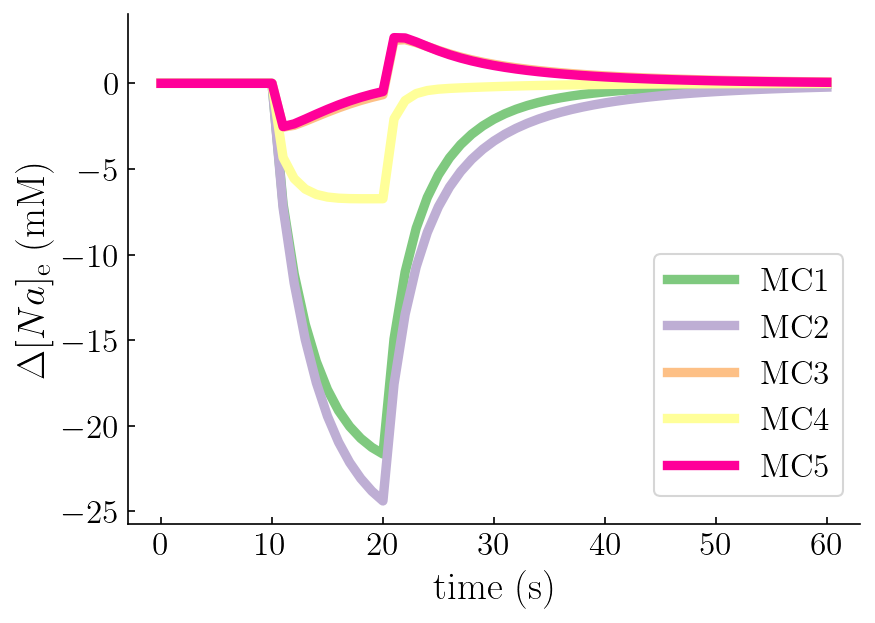

In [26]:
fig = plt.figure(figsize=(7*fs, 5*fs))
ax = plt.gca()
for i, line in enumerate(plot_list):
    plt.plot(line, color=color_list[i], label=legend[i], linewidth=lw)
if len(plot_list) > 1:
    plt.figlegend(bbox_to_anchor=(0.9, 0.55), frameon=True)

plt.xlabel(xlabel, fontsize=fosi)
plt.ylabel(ylabel, fontsize=fosi)
# make pretty
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

## If you want to save the figure
Change the figure name below.

In [27]:
figname = 'Cle_timeplot'

In [28]:
fig.savefig('results/figures/' + figname, dpi='figure', bbox_inches='tight')

## Spaceplots and water velocity!
Add the plots you want to the list and the corresponding x and y labels. The spacedata is setup as $d[k]\_i$ for all the ions and $dp\_m$. The rest have $\_space$ such as $phi\_m\_space$, $j\_in\_space$ and $dalpha\_e\_space$.

The water velocities are saved as $u\_i/e\_hyd/osm/tot$. For example, you can plot MC1.u_i_osm

In [74]:
plotlist = [MC1.dNa_e, MC2.dNa_e, MC3.dNa_e, MC4.dNa_e, MC5.dNa_e]
ylabel = r'$\Delta []_\mathrm{e}$ (mM)'
legend = ['MC1', 'MC2', 'MC3', 'MC4', 'MC5']
print(MC2.Na_e[0])
print(MC2.model.Na_e_init)

140.49833715718293
140.49833715718293


Text(0.5, 0, '$x$ (um)')

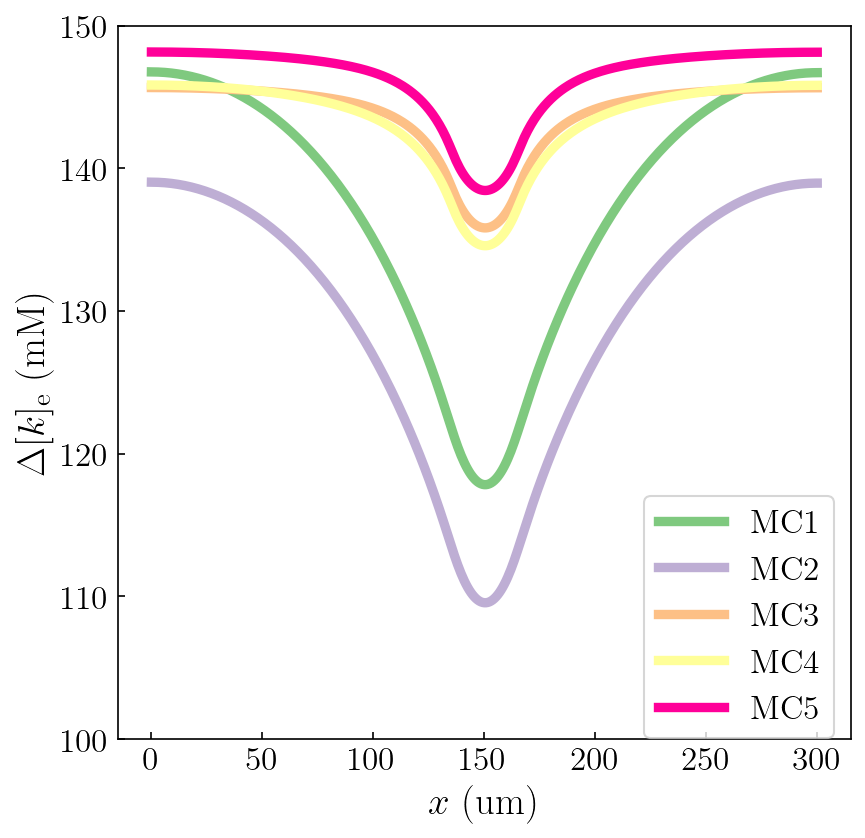

In [78]:
fig = plt.figure(figsize=(7*fs, 7*fs))
ax = plt.gca()
for i, line in enumerate(plotlist):
    df.plot(line, color=color_list[i], label=legend[i], linewidth=lw)
if len(plotlist) > 1:
    plt.figlegend(bbox_to_anchor=(0.9, 0.4), frameon=True)
plt.ylim([100, 150])
plt.xticks(xticks, xticklabels)
plt.ylabel(ylabel, fontsize=fosi)
plt.xlabel(xlabel_x, fontsize=fosi)

In [79]:
figname = 'Na_e_spaceplots'
fig.savefig('results/figures/' + figname, dpi='figure', bbox_inches='tight')

In [4]:
path_figs = 'results/figures/'
model_v = 'MC2'
j_in = 1.0e-6                # input constant (mol/(m^2s))
Tstop = 60                   # duration of simulation (s)
stim_start = 10              # stimulus onset (s)
stim_end = 20                # stimulus offset (s)
n = stim_end
stim_protocol = 'constant'   # stimulus protocol ('constant', 'slow', or 'ultraslow')
# mesh
N = 400                                  # mesh size
L = 3.0e-4                               # m (300 um)
dt_value = 1e-3                          # time step (s)
t_PDE = df.Constant(0.0)  # time constant
mesh = df.IntervalMesh(N, 0, L)          # create mesh
model = ModelMC2(model_v, mesh, L, t_PDE, j_in, stim_start, stim_end, stim_protocol)
P = Plotter(model, 'results/data/MC2/')

In [5]:
P.timeplot(path_figs, model_v, Tstop)

alpha_i final = 3.176772525592675e-06
alpha_e final = -6.353545078940925e-06
Na_i final = 15.826417449226858
Na_e final = 140.2323712304974
K_i final = 102.11348507563108
K_e final = 2.8875659371832043
Cl_i final = 8.289178465285248
Cl_i final = 127.42139125638063
phi_i final = -0.085705717294045
phi_e final = -7.15219647516989e-09
j_pump final = 0.4906615366473928
